In [27]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
import pickle

# Load processed dataset
data_path = "../data/dataset.csv"
df = pd.read_csv(data_path)

# Display the first few rows
df.head()


,number_of_rentals,season,month,hour,is_holiday,is_weekend,temp_C,humidity_percent,wind_speed_kmh,weather_code
0,182,3,1,0,0,1,3.0,93.0,6.0,3
1,138,3,1,1,0,1,3.0,93.0,5.0,1
2,134,3,1,2,0,1,2.5,96.5,0.0,1
3,72,3,1,3,0,1,2.0,100.0,0.0,1
4,47,3,1,4,0,1,2.0,93.0,6.5,1


In [28]:
# User-defined parameters
rand_state = 42  # Random seed
cv_num = 5       # Number of folds in cross-validation

# Define target and features
target = "number_of_rentals"
features = [col for col in df.columns if col != target]

# Wybór cech liczbowych do normalizacji
numerical_features = ["temp_C", "humidity_percent", "wind_speed_kmh"]

# Normalizacja tylko cech liczbowych
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Save the scaler to a file
scaler_path = "../models/scaler.pkl"
with open(scaler_path, "wb") as file:
    pickle.dump(scaler, file)

# Podział na zbiory treningowe i testowe
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

print(f"Training set: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing set: X_test={X_test.shape}, y_test={y_test.shape}")


Training set: X_train=(13931, 9), y_train=(13931,)
Testing set: X_test=(3483, 9), y_test=(3483,)


In [29]:
# Define models with default hyperparameters
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1, random_state=rand_state),
    'Lasso': Lasso(alpha=0.1),
    'Elastic Net': ElasticNet(alpha=0.1, l1_ratio=0.7),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=rand_state),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=rand_state),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=rand_state),
    'SVR (RBF Kernel)': SVR(kernel='rbf', C=100, gamma='scale'),
    'Decision Tree': DecisionTreeRegressor(max_depth=5, random_state=rand_state)
}

In [30]:
# Function to evaluate models using cross-validation
def evaluate_model(model, X, y):
    cv = KFold(n_splits=cv_num, shuffle=True, random_state=rand_state)
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    return -scores.mean()  # Return the mean negative RMSE


In [31]:
# Evaluate models
results = {}
for name, model in models.items():
    rmse = evaluate_model(model, X_train, y_train)
    results[name] = rmse

# Display results
print("Model performance (RMSE):")
for name, score in sorted(results.items(), key=lambda x: x[1]):
    print(f"{name}: RMSE = {score:.4f}")

Model performance (RMSE):
Random Forest: RMSE = 274.6689
Gradient Boosting: RMSE = 375.2945
XGBoost: RMSE = 377.5064
Decision Tree: RMSE = 625.2593
SVR (RBF Kernel): RMSE = 850.6224
Ridge: RMSE = 901.7526
Linear Regression: RMSE = 901.7527
Lasso: RMSE = 901.7531
Elastic Net: RMSE = 902.2356


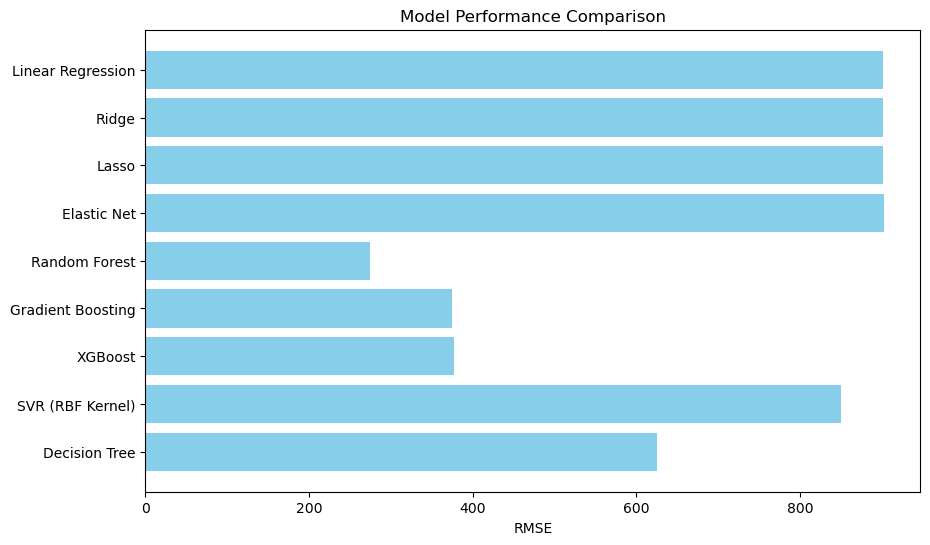

In [32]:
# Plot model performance
plt.figure(figsize=(10, 6))
model_names = list(results.keys())
rmse_scores = list(results.values())
plt.barh(model_names, rmse_scores, color='skyblue')
plt.xlabel("RMSE")
plt.title("Model Performance Comparison")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

In [33]:
# Select top 3 models
top_models = sorted(results.items(), key=lambda x: x[1])[:3]
print("Top 3 models:")
for name, score in top_models:
    print(f"{name}: RMSE = {score:.4f}")


Top 3 models:
Random Forest: RMSE = 274.6689
Gradient Boosting: RMSE = 375.2945
XGBoost: RMSE = 377.5064


# Hyperparametrisation for Random Forest

In [34]:
# Define Random Forest model
random_forest = RandomForestRegressor(random_state=42)

# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [500, 800],      
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid search for Random Forest
grid_search_rf = GridSearchCV(estimator=random_forest, param_grid=param_grid_rf, scoring='neg_root_mean_squared_error', cv=cv, verbose=1)

# Perform grid search
grid_search_rf.fit(X_train, y_train)

# Best model and metrics
best_rf = grid_search_rf.best_estimator_
print("------- Random Forest - Hyperparameters Grid Search results ---------\n")
print("The best score (RMSE):", -grid_search_rf.best_score_)
print("The best parameters:", grid_search_rf.best_params_)
print("\n-----------------------------\n")


Fitting 5 folds for each of 24 candidates, totalling 120 fits
------- Random Forest - Hyperparameters Grid Search results ---------

The best score (RMSE): 251.62613848181257
The best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 800}

-----------------------------



Visualise the results

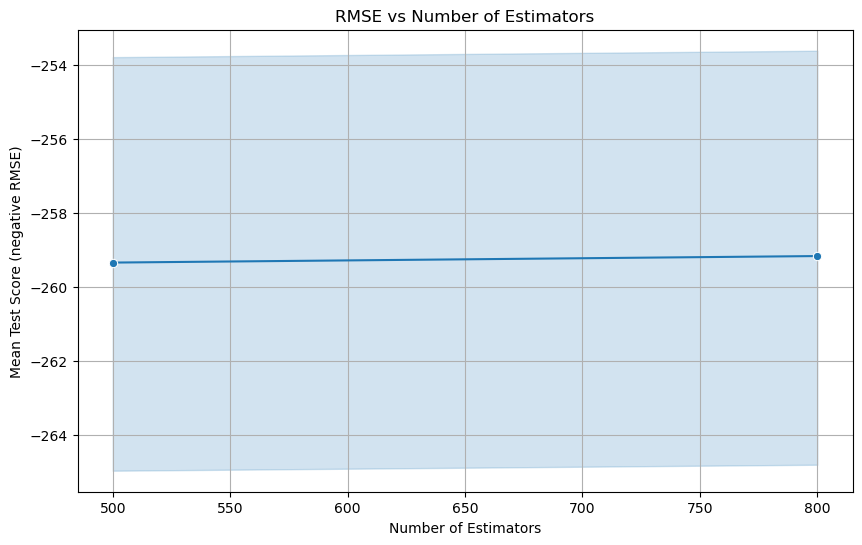

In [35]:
# Przechwycenie wyników Grid Search
results = pd.DataFrame(grid_search_rf.cv_results_)

# Wizualizacja wyników dla różnych liczby drzew (n_estimators)
plt.figure(figsize=(10, 6))
sns.lineplot(data=results, x="param_n_estimators", y="mean_test_score", marker="o")
plt.title("RMSE vs Number of Estimators")
plt.xlabel("Number of Estimators")
plt.ylabel("Mean Test Score (negative RMSE)")
plt.grid()
plt.show()


Save best model

In [36]:
import pickle

# Save the best Random Forest model
model_path = "../models/best_random_forest.pkl"
with open(model_path, "wb") as file:
    pickle.dump(best_rf, file)

print(f"Best Random Forest model saved to {model_path}")


Best Random Forest model saved to ../models/best_random_forest.pkl


# Hyperparametrization for Gradient Boosting

In [37]:
# Define Gradient Boosting model
gradient_boosting = GradientBoostingRegressor(random_state=42)

# Cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 10, None]
}

# Grid search for Gradient Boosting
grid_search_gb = GridSearchCV(estimator=gradient_boosting, param_grid=param_grid_gb, scoring='neg_root_mean_squared_error', cv=cv, verbose=1)

# Perform grid search
grid_search_gb.fit(X_train, y_train)

# Best model and metrics
best_gb = grid_search_gb.best_estimator_
print("------- Gradient Boosting - Hyperparameters Grid Search results ---------\n")
print("The best score (RMSE):", -grid_search_gb.best_score_)
print("The best parameters:", grid_search_gb.best_params_)
print("\n-----------------------------\n")


Fitting 5 folds for each of 36 candidates, totalling 180 fits
------- Gradient Boosting - Hyperparameters Grid Search results ---------

The best score (RMSE): 247.61754373629256
The best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}

-----------------------------



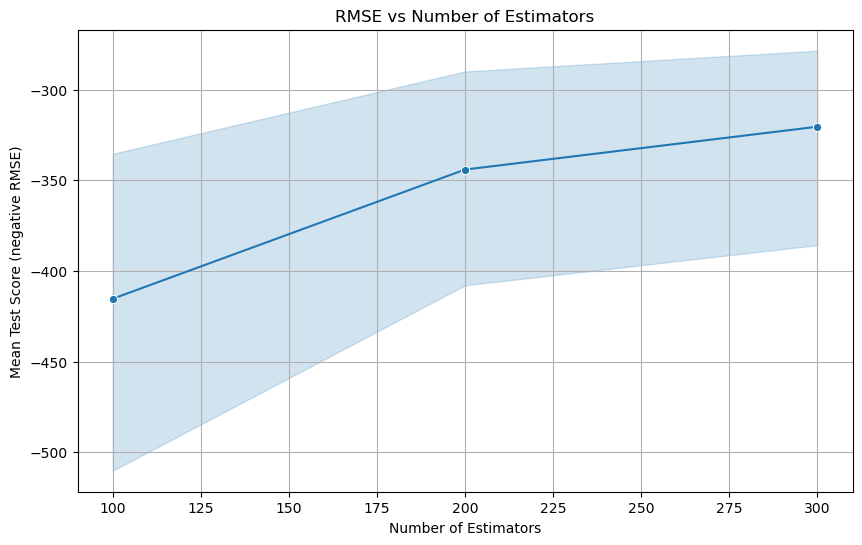

In [38]:
# Przechwycenie wyników Grid Search
results = pd.DataFrame(grid_search_gb.cv_results_)

# Wizualizacja wyników dla różnych liczby drzew (n_estimators)
plt.figure(figsize=(10, 6))
sns.lineplot(data=results, x="param_n_estimators", y="mean_test_score", marker="o")
plt.title("RMSE vs Number of Estimators")
plt.xlabel("Number of Estimators")
plt.ylabel("Mean Test Score (negative RMSE)")
plt.grid()
plt.show()

In [15]:
# Save the best  model
model_path = "../models/best_gradient_boosting.pkl"
with open(model_path, "wb") as file:
    pickle.dump(best_rf, file)

print(f"Best Gradient Boosting model saved to {model_path}")

Best Gradient Boosting model saved to ../models/best_gradient_boosting.pkl


# Hyperparametrization for XGBoost

In [39]:
# Define XGBoost model
xgboost = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'subsample': [0.8, 1.0]
}

# Grid search for XGBoost
grid_search_xgb = GridSearchCV(estimator=xgboost, param_grid=param_grid_xgb, scoring='neg_root_mean_squared_error', cv=cv, verbose=1)

# Perform grid search
grid_search_xgb.fit(X_train, y_train)

# Best model and metrics
best_xgb = grid_search_xgb.best_estimator_
print("------- XGBoost - Hyperparameters Grid Search results ---------\n")
print("The best score (RMSE):", -grid_search_xgb.best_score_)
print("The best parameters:", grid_search_xgb.best_params_)
print("\n-----------------------------\n")


Fitting 5 folds for each of 54 candidates, totalling 270 fits
------- XGBoost - Hyperparameters Grid Search results ---------

The best score (RMSE): 238.52436360099813
The best parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}

-----------------------------



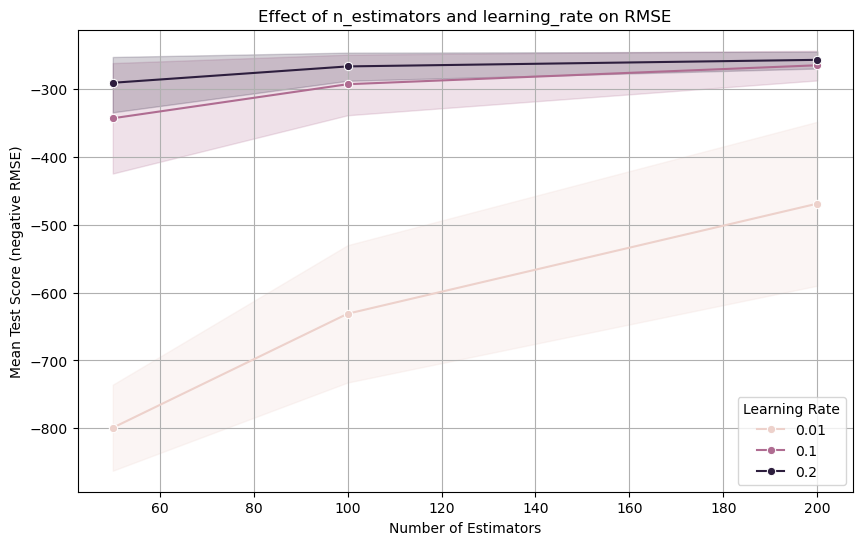

In [17]:
# Przechwycenie wyników Grid Search
results = pd.DataFrame(grid_search_xgb.cv_results_)

# Wizualizacja wpływu learning_rate na RMSE
plt.figure(figsize=(10, 6))
sns.lineplot(data=results, x="param_n_estimators", y="mean_test_score", marker="o", hue="param_learning_rate")
plt.title("Effect of n_estimators and learning_rate on RMSE")
plt.xlabel("Number of Estimators")
plt.ylabel("Mean Test Score (negative RMSE)")
plt.legend(title="Learning Rate")
plt.grid()
plt.show()


In [40]:
# Save the best XGBoost model
model_path = "../models/best_xgboost.pkl"
with open(model_path, "wb") as file:
    pickle.dump(best_xgb, file)

print(f"Best XGBoost model saved to {model_path}")


Best XGBoost model saved to ../models/best_xgboost.pkl


# Comparison

In [41]:
# Test data predictions for best models
y_pred_rf = best_rf.predict(X_test)
y_pred_gb = best_gb.predict(X_test)
y_pred_xgb = best_xgb.predict(X_test)

# Metrics for each model
def evaluate_metrics(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    explained_variance = explained_variance_score(y_true, y_pred)
    print(f"--- {model_name} ---")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R-squared (R²): {r2:.2f}")
    print(f"Explained Variance Score: {explained_variance:.2f}")
    print()

evaluate_metrics(y_test, y_pred_rf, "Random Forest")
evaluate_metrics(y_test, y_pred_gb, "Gradient Boosting")
evaluate_metrics(y_test, y_pred_xgb, "XGBoost")


--- Random Forest ---
Mean Squared Error (MSE): 56766.62
Root Mean Squared Error (RMSE): 238.26
Mean Absolute Error (MAE): 135.79
R-squared (R²): 0.95
Explained Variance Score: 0.95

--- Gradient Boosting ---
Mean Squared Error (MSE): 58425.06
Root Mean Squared Error (RMSE): 241.71
Mean Absolute Error (MAE): 142.36
R-squared (R²): 0.95
Explained Variance Score: 0.95

--- XGBoost ---
Mean Squared Error (MSE): 53955.54
Root Mean Squared Error (RMSE): 232.28
Mean Absolute Error (MAE): 131.21
R-squared (R²): 0.95
Explained Variance Score: 0.95



# Feature Importance for RF and XGBoost

In [42]:
# Feature importance for Random Forest
rf_importances = best_rf.feature_importances_
rf_features = {feature: importance for feature, importance in zip(features, rf_importances)}

print("\nFeature Importances - Random Forest:")
for feature, importance in sorted(rf_features.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")

# Feature importance for XGBoost
xgb_importances = best_xgb.feature_importances_
xgb_features = {feature: importance for feature, importance in zip(features, xgb_importances)}

print("\nFeature Importances - XGBoost:")
for feature, importance in sorted(xgb_features.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")



Feature Importances - Random Forest:
hour: 0.7231
temp_C: 0.0925
is_weekend: 0.0781
humidity_percent: 0.0400
is_holiday: 0.0193
weather_code: 0.0174
wind_speed_kmh: 0.0130
month: 0.0091
season: 0.0075

Feature Importances - XGBoost:
hour: 0.4690
is_weekend: 0.1936
is_holiday: 0.1672
temp_C: 0.0620
weather_code: 0.0366
humidity_percent: 0.0274
season: 0.0214
month: 0.0137
wind_speed_kmh: 0.0091
